# Exploratory Data Analysis

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

### Reading sensor files

In [2]:
files = [file for file in os.listdir('../../Processed Sensors')]
files.sort()
read_files = []
for file in files:
    read_files.append(pd.read_csv('../../Processed Sensors/' + file))

### Removing sensors that don't appear across every user run

In [3]:
cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]
common_els = reduce(set.intersection, (set(item) for item in cols_file))
common_els = list(common_els)
read_files = [read_files[i][common_els] for i in range(len(read_files))]

### Reading the downtime data file and filtering out onlt the ion source failures

In [4]:
downtimeNew = pd.read_excel('../../Raw Data/Equipment downtime data (202310).xlsx')
downtimeNew['FaultDate'] = pd.to_datetime(downtimeNew['FaultDate'], errors='coerce').dt.date
downtimeNew['FaultTime'] = downtimeNew['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)
downtimeNew = downtimeNew.dropna(subset=['FaultDate', 'FaultTime'])
pattern_new = downtimeNew.iloc[:, :14]
pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)
pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))
pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)
pattern_new.sort_values(by=['FaultDateTime'], inplace=True)
pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)
pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')
pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

/var/folders/nl/8bkjfnbd2k53t1p3_gjy6k9h0000gn/T/ipykernel_11507/573615324.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '')


### Integrating the fail points in the sensor files

In [5]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']
isrcFailRuns = [pattern_new[pattern_new['User Run'] == ur] for ur in userruns]

ct = 0
for i in range(len(read_files)):
    read_files[i]['Label'] = -1
    read_files[i]['failCount'] = ct
    read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
    for j in range(read_files[i].shape[0]-1):
        read_files[i].loc[j, 'failCount'] = ct
        read_files[i].loc[j+1, 'failCount'] = ct
        for el in isrcFailRuns[i]['FaultDateTime']:
            if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                read_files[i].loc[j, 'Label'] = 0   #['Label'][j] = 1
                ct+=1
                break

### Describe

In [6]:
print(read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])].describe())

       irfq::gas:set_press  irfq::solenoid_2:set_current  \
count         74881.000000                  74881.000000   
mean              2.404750                     38.450260   
std               0.059017                      6.678882   
min               2.100000                     36.511111   
25%               2.400000                     36.511111   
50%               2.400000                     36.511111   
75%               2.400000                     36.511111   
max               3.000000                     67.480000   

       irfq::boiler:read_temp  irfq::arc_pulser_intlk:sta  \
count            74881.000000                74881.000000   
mean               157.365331                    0.970941   
std                 10.617381                    0.121107   
min                  2.138588                    0.000000   
25%                157.054667                    1.000000   
50%                157.054667                    1.000000   
75%                157.054667   

### Plotting the sensor value change as bar plots 

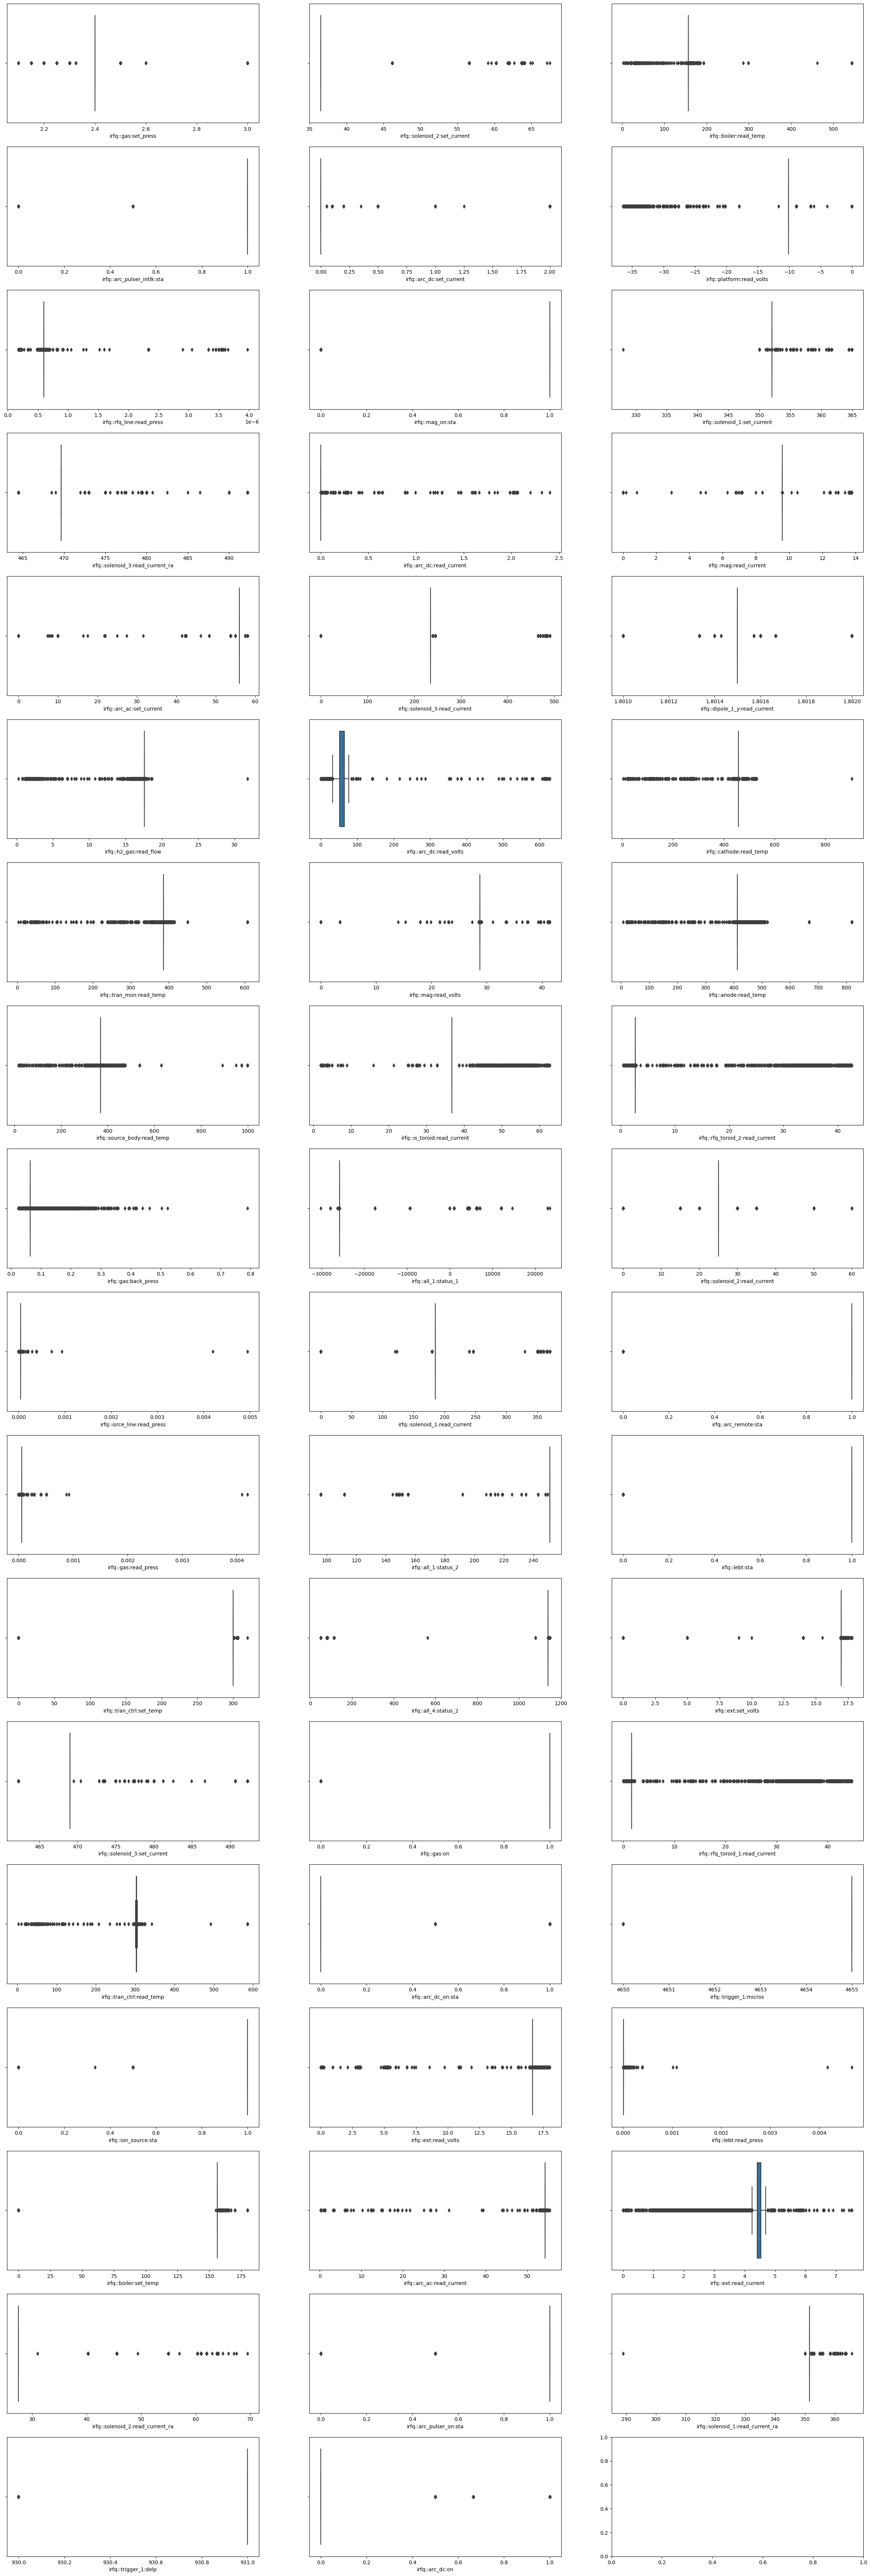

In [7]:
data = read_files[0].copy()

fig, ax = plt.subplots(18, 3,figsize=(30, 90))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.boxplot(data=data, x = column, ax=ax.ravel()[i])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this war

LinAlgError: singular matrix

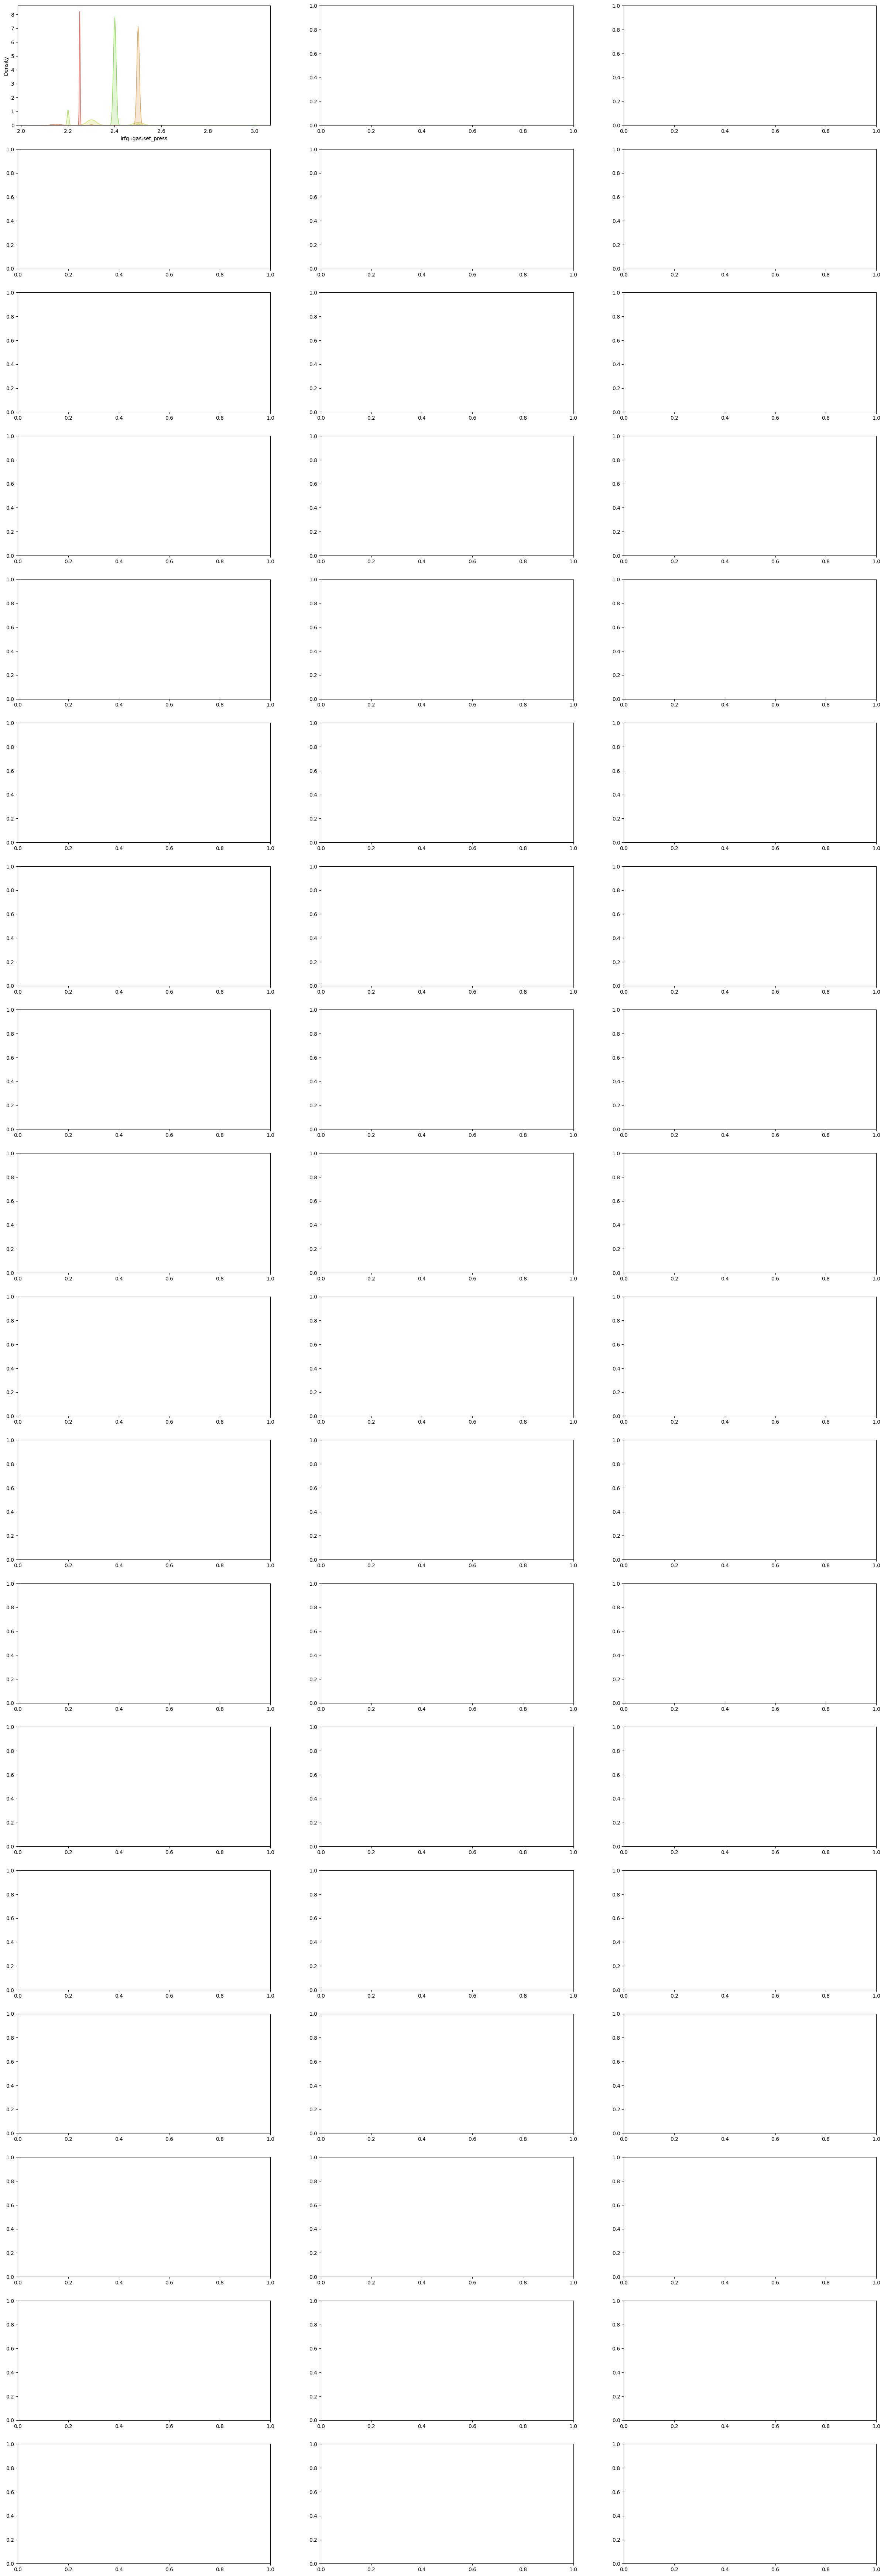

In [8]:
fig, ax = plt.subplots(18, 3,figsize=(30, 90))

for i,column in enumerate(data.columns.drop(['Time', 'Label', 'failCount'])):
    sns.kdeplot(data=data, x=column, hue='failCount', palette='hls', ax=ax.ravel()[i], fill=True, legend=False)

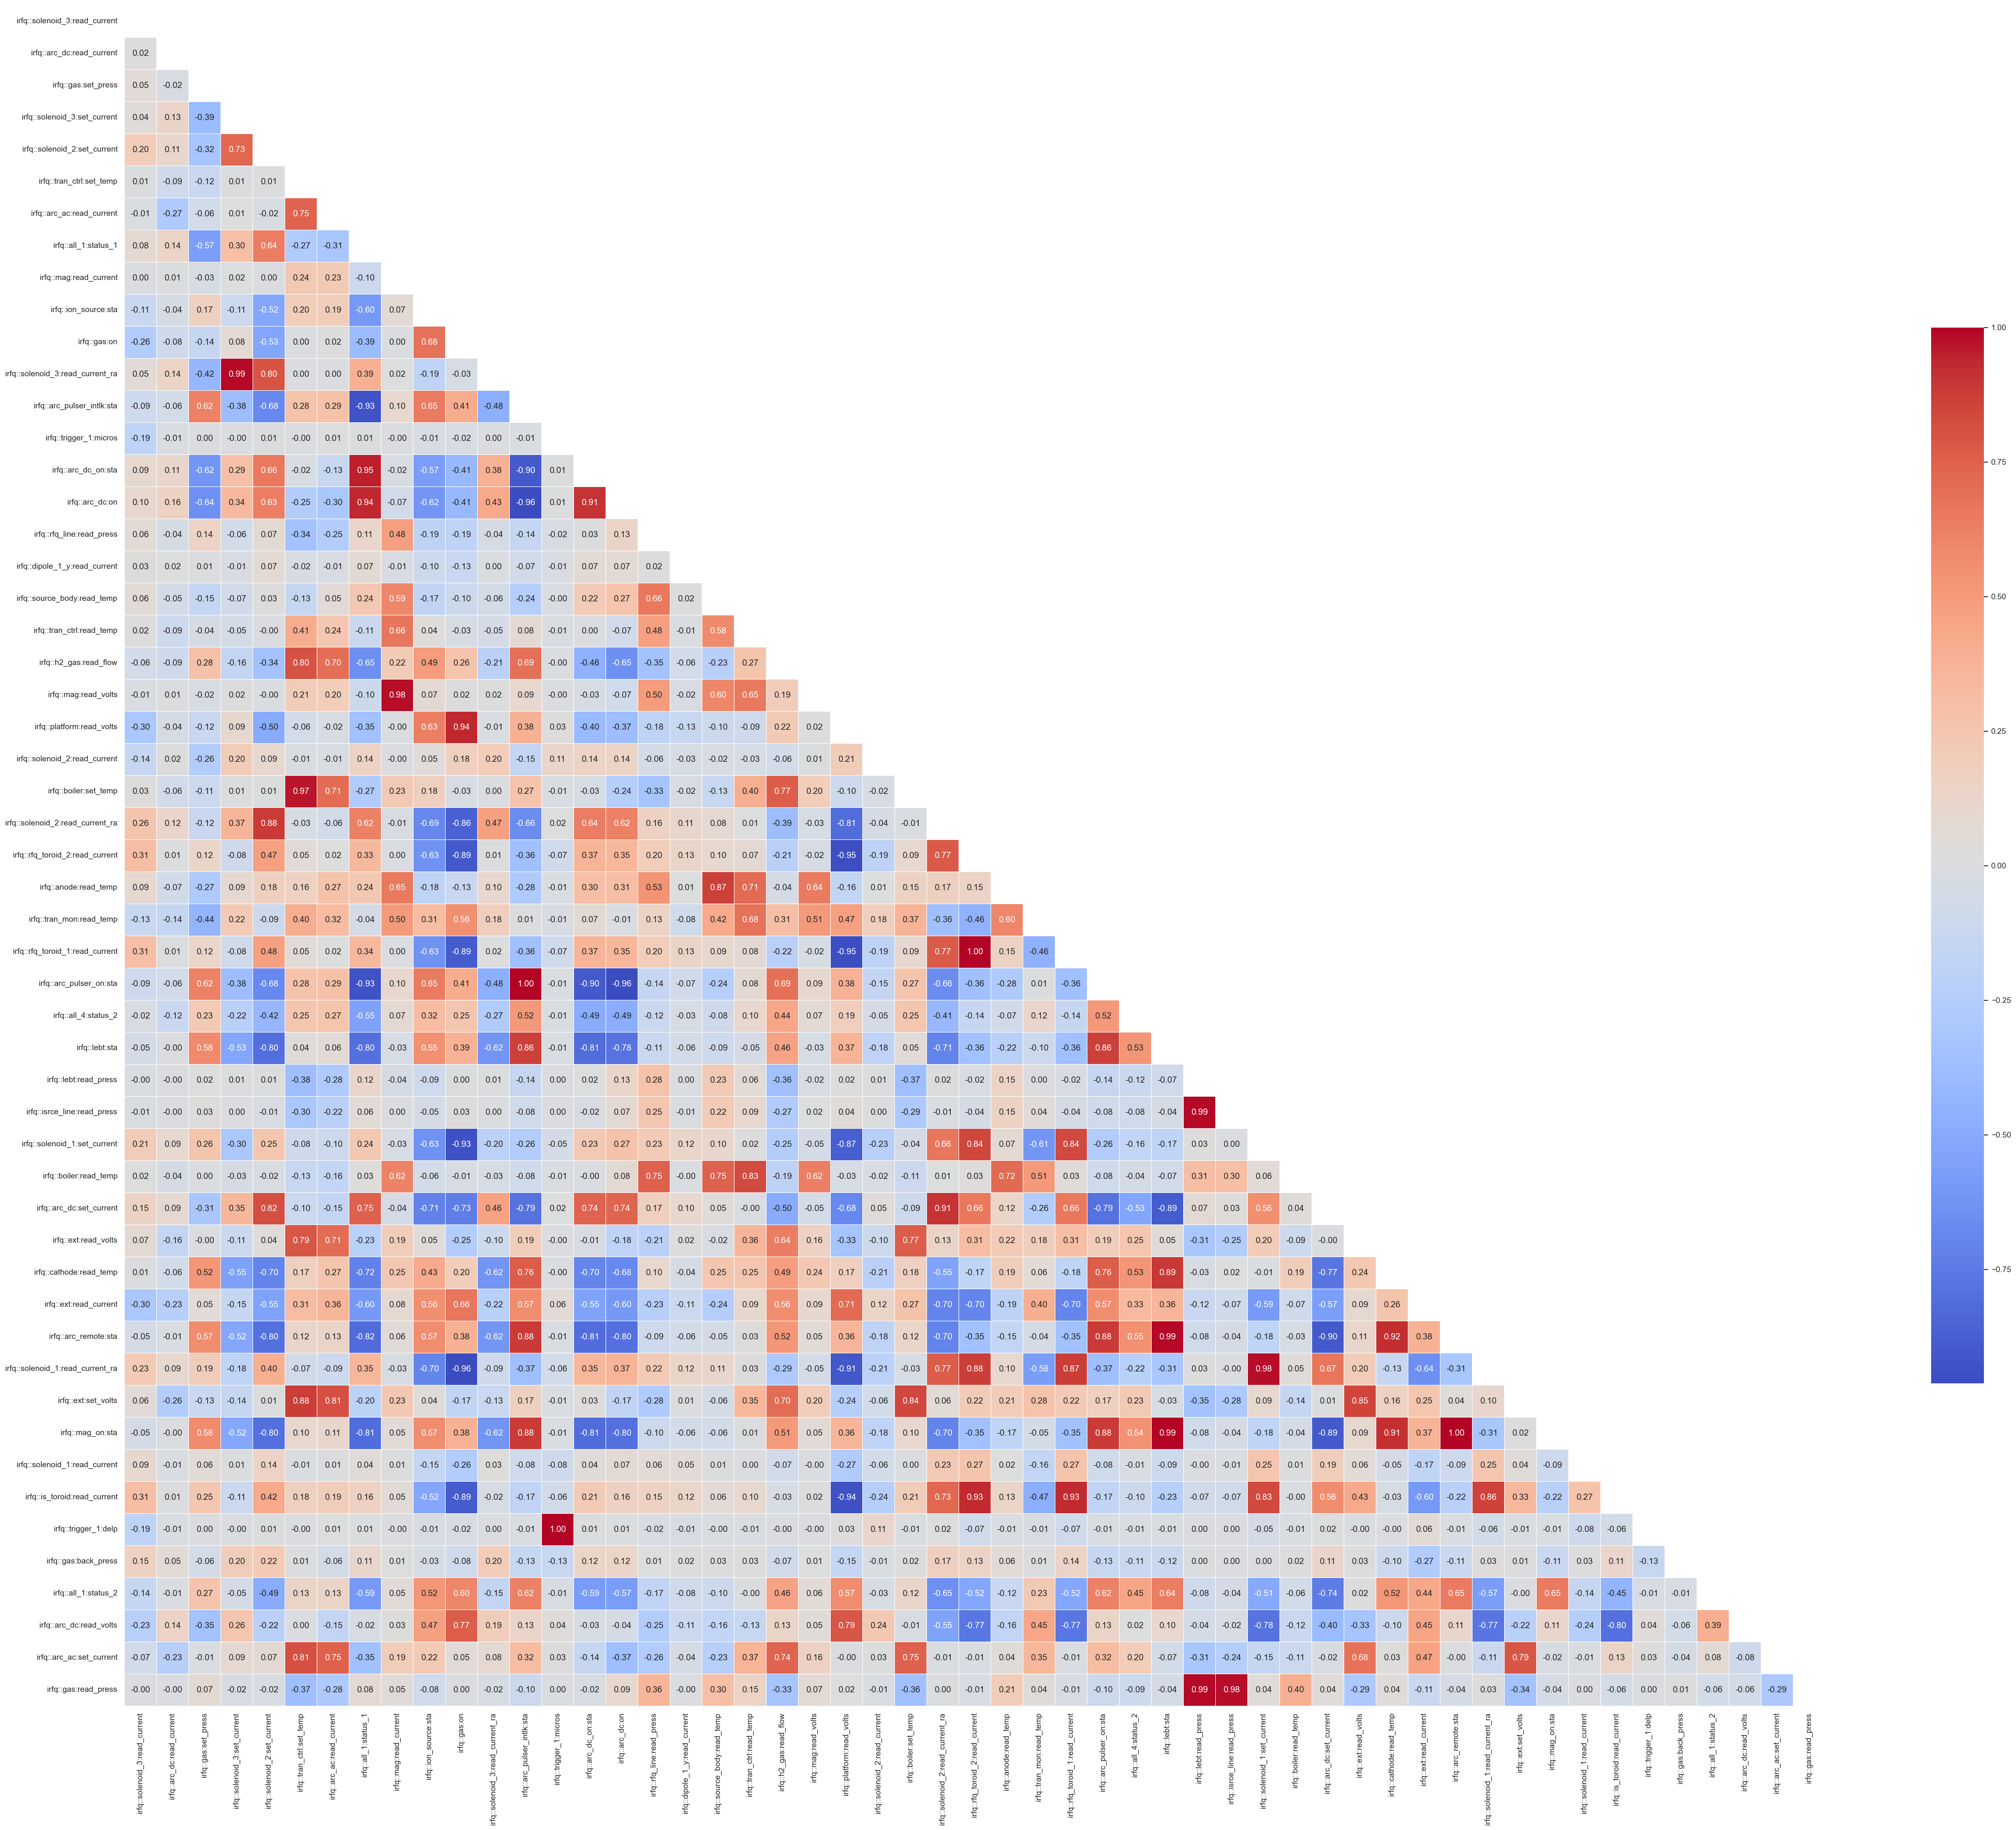

In [ ]:
data = read_files[0][read_files[0].columns.drop(['Time', 'Label', 'failCount'])]

corr = data.corr()

sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(53, 53))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
corr_matrix = data.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

print(len(to_drop), to_drop)

16 ['irfq::solenoid_3:read_current_ra', 'irfq::arc_dc_on:sta', 'irfq::arc_dc:on', 'irfq::mag:read_volts', 'irfq::platform:read_volts', 'irfq::boiler:set_temp', 'irfq::rfq_toroid_1:read_current', 'irfq::arc_pulser_on:sta', 'irfq::isrce_line:read_press', 'irfq::arc_dc:set_current', 'irfq::arc_remote:sta', 'irfq::solenoid_1:read_current_ra', 'irfq::mag_on:sta', 'irfq::is_toroid:read_current', 'irfq::trigger_1:delp', 'irfq::gas:read_press']


In [ ]:
actual_data = read_files.copy()
actual_data
for i in range(len(actual_data)):
    actual_data[i].drop(to_drop, axis=1, inplace=True)

In [ ]:
actual_data[0]

,irfq::solenoid_3:read_current,irfq::arc_dc:read_current,irfq::gas:set_press,irfq::solenoid_3:set_current,irfq::solenoid_2:set_current,irfq::tran_ctrl:set_temp,irfq::arc_ac:read_current,irfq::all_1:status_1,irfq::mag:read_current,irfq::ion_source:sta,...,irfq::cathode:read_temp,irfq::ext:read_current,irfq::ext:set_volts,irfq::solenoid_1:read_current,irfq::gas:back_press,irfq::all_1:status_2,irfq::arc_dc:read_volts,irfq::arc_ac:set_current,Label,failCount
0,240.0,0.00366,2.25,476.166667,61.833333,305.0,54.252291,-9353.0,9.58676,0.5,...,278.038010,3.126547,17.500000,180.0,0.0775,151.0,51.728000,58.064459,-1,0
1,240.0,0.00366,2.25,476.166667,61.833333,305.0,54.276986,-9353.0,9.58188,0.5,...,278.038010,3.129876,17.500000,180.0,0.0775,151.0,52.216000,58.064459,-1,0
2,240.0,0.00366,2.25,476.166667,61.833333,305.0,54.273225,-9353.0,9.58432,0.5,...,278.038010,3.133478,17.500000,180.0,0.0775,151.0,51.955733,58.064459,-1,0
3,240.0,0.00366,2.25,476.166667,61.833333,305.0,54.301386,-9353.0,9.58188,0.5,...,278.038010,3.132096,17.500000,180.0,0.0846,151.0,51.890666,58.064459,-1,0
4,240.0,0.00366,2.25,476.166667,61.833333,305.0,54.266820,-9353.0,9.58188,0.5,...,278.024455,3.134945,17.500000,180.0,0.0795,151.0,51.850000,58.064459,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74876,235.0,0.00122,2.40,469.000000,36.511111,300.0,54.241199,-25737.0,9.58676,1.0,...,458.232025,4.528751,16.950001,185.0,0.0640,251.0,64.660004,56.000000,-1,23
74877,235.0,0.00122,2.40,469.000000,36.511111,300.0,54.241199,-25737.0,9.58676,1.0,...,458.232025,4.528751,16.950001,185.0,0.0640,251.0,64.660004,56.000000,-1,23
74878,235.0,0.00122,2.40,469.000000,36.511111,300.0,54.241199,-25737.0,9.58676,1.0,...,458.232025,4.528751,16.950001,185.0,0.0640,251.0,64.660004,56.000000,-1,23
74879,235.0,0.00122,2.40,469.000000,36.511111,300.0,54.241199,-25737.0,9.58676,1.0,...,458.232025,4.528751,16.950001,185.0,0.0640,251.0,64.660004,56.000000,-1,23
